# Out-of-Distribution Detection

In [1]:
import os
import sys
import torch

current_dir = os.getcwd()
openood_dir = os.path.abspath(os.path.join(current_dir, '../OpenOOD/')) 

if openood_dir not in sys.path:
    sys.path.append(openood_dir)

from openood.networks import ResNet18_32x32
from openood.evaluation_api import Evaluator, datasets

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [3]:
net = ResNet18_32x32(num_classes=100) # num_class=100 (CIFAR-100)
net.load_state_dict(
    torch.load('cifar100_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt', 
               map_location=device)
)
net.to(device)
# net.eval()

ResNet18_32x32(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [4]:
# from torchsummary import summary
# summary(net, (3, 32, 32))

In [5]:
# from torchviz import make_dot

# # Define the model

# # Create a dummy input tensor
# x = torch.randn(1, 3, 32, 32)

# # Forward pass through the model
# y = net(x)

# # Visualize the model computation graph
# graph = make_dot(y, params=dict(net.named_parameters()))
# graph.render("resnet18_32x32", format="png")


In [6]:
postprocessor_name = "msp"

In [7]:

evaluator = Evaluator(
    net,
    id_name='cifar100',                     # the target ID dataset
    data_root='./data',                    # change if necessary
    config_root=None,                      # see notes above
    preprocessor=None,                     # default preprocessing for the target ID dataset
    postprocessor_name=postprocessor_name, # the postprocessor to use
    postprocessor=None,                    # if you want to use your own postprocessor
    batch_size=128,                        # for certain methods the results can be slightly affected by batch size
    shuffle=False,
    num_workers=2
    )                         # could use more num_workers outside colab

In [8]:
metrics = evaluator.eval_ood(fsood=False)

Performing inference on cifar100 test set...


100%|██████████| 71/71 [00:18<00:00,  3.74it/s]

Processing near ood...
Performing inference on cifar10 dataset...



100%|██████████| 79/79 [00:20<00:00,  3.87it/s]

Computing metrics on cifar10 dataset...
FPR@95: 59.12, AUROC: 78.54 AUPR_IN: 79.50, AUPR_OUT: 75.97
──────────────────────────────────────────────────────────────────────

Performing inference on tin dataset...



100%|██████████| 51/51 [00:18<00:00,  2.80it/s]

Computing metrics on tin dataset...
FPR@95: 50.38, AUROC: 82.30 AUPR_IN: 87.93, AUPR_OUT: 72.54
──────────────────────────────────────────────────────────────────────

Computing mean metrics...
FPR@95: 54.75, AUROC: 80.42 AUPR_IN: 83.72, AUPR_OUT: 74.26
──────────────────────────────────────────────────────────────────────




ID Acc Eval: 100%|██████████| 71/71 [00:19<00:00,  3.72it/s]

         FPR@95  AUROC  AUPR_IN  AUPR_OUT   ACC
cifar10   59.12  78.54    79.50     75.97 77.17
tin       50.38  82.30    87.93     72.54 77.17
nearood   54.75  80.42    83.72     74.26 77.17


In [13]:
print('Components within evaluator.metrics:\t', evaluator.metrics.keys())
print('Components within evaluator.scores:\t', evaluator.scores.keys())
print('')
print('The predicted ID class of the first 10 samples of CIFAR-10:\t', evaluator.scores['ood']['near']['cifar10'][0][:10])
print('The OOD score of the first 10 samples of CIFAR-10:\t', evaluator.scores['ood']['near']['cifar10'][1][:10])
print('')
print('The predicted ID class of the first 10 samples of TinyImageNet:\t', evaluator.scores['ood']['near']['tin'][0][:10])
print('The OOD score of the first 10 samples of TinyImageNet:\t', evaluator.scores['ood']['near']['tin'][1][:10])

Components within evaluator.metrics:	 dict_keys(['id_acc', 'csid_acc', 'ood', 'fsood'])
Components within evaluator.scores:	 dict_keys(['id', 'csid', 'ood', 'id_preds', 'id_labels', 'csid_preds', 'csid_labels'])

The predicted ID class of the first 10 samples of CIFAR-10:	 [16 64 95 44 13 34 48 85 56 70]
The OOD score of the first 10 samples of CIFAR-10:	 [0.253 0.605 0.952 0.961 0.978 0.126 0.73  0.497 0.596 0.347]

The predicted ID class of the first 10 samples of TinyImageNet:	 [13 23 94 27 18 71 18 79 35 74]
The OOD score of the first 10 samples of TinyImageNet:	 [0.504 0.366 0.257 0.275 0.998 0.191 0.168 0.823 0.226 0.39 ]


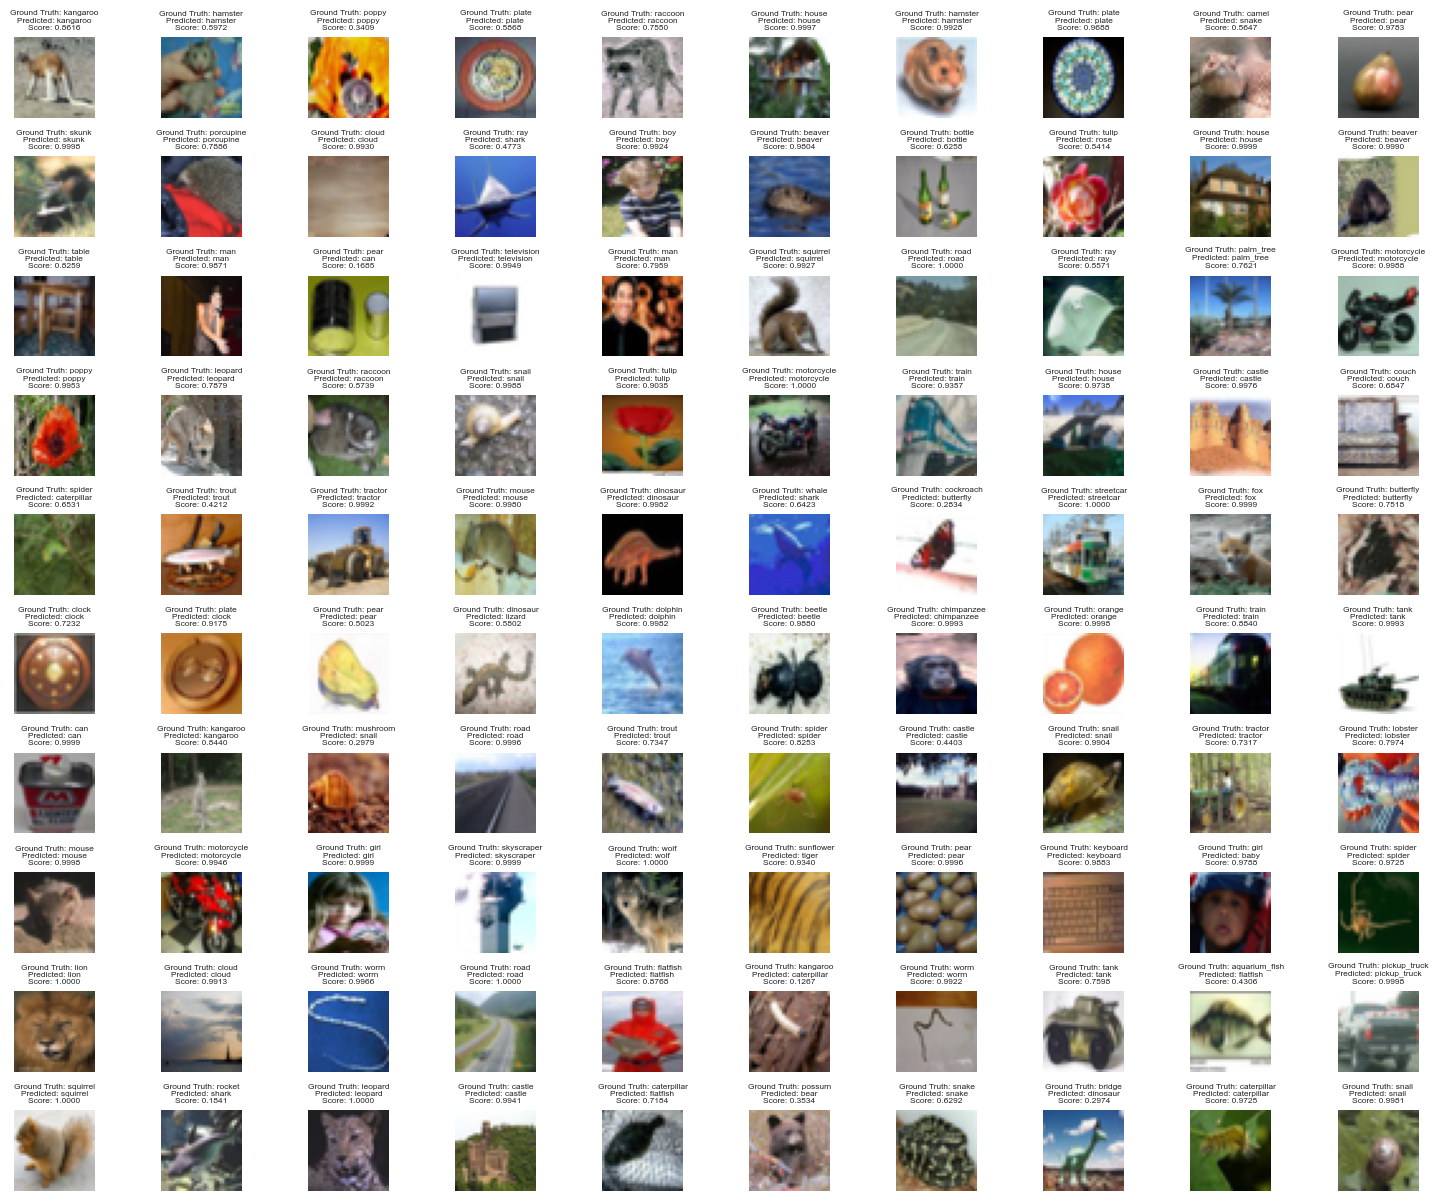

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Extract data
id_gt = evaluator.scores['id']['test'][0]
id_conf = evaluator.scores['id']['test'][1]
id_pred = evaluator.scores['id']['test'][2]
id_file_paths = evaluator.scores['id']['test'][3]

# Number of images to display
num_images_to_display = 100

classes_cifar100 = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

# Select 20 random indices
random_indices = np.random.choice(len(id_gt), num_images_to_display, replace=False)

# Create a figure and axis for plotting
fig, axes = plt.subplots(10, 10, figsize=(15, 12))

# Display the randomly selected images in a grid
for i, idx in enumerate(random_indices):
    row = i // 10
    col = i % 10
    
    image_path = id_file_paths[idx]
    img = mpimg.imread(image_path)
    ground_truth = classes[id_gt[idx]]
    predicted_label = classes[id_pred[idx]]
    score = id_conf[idx]

    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Ground Truth: {ground_truth}\nPredicted: {predicted_label}\nScore: {score:.4f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


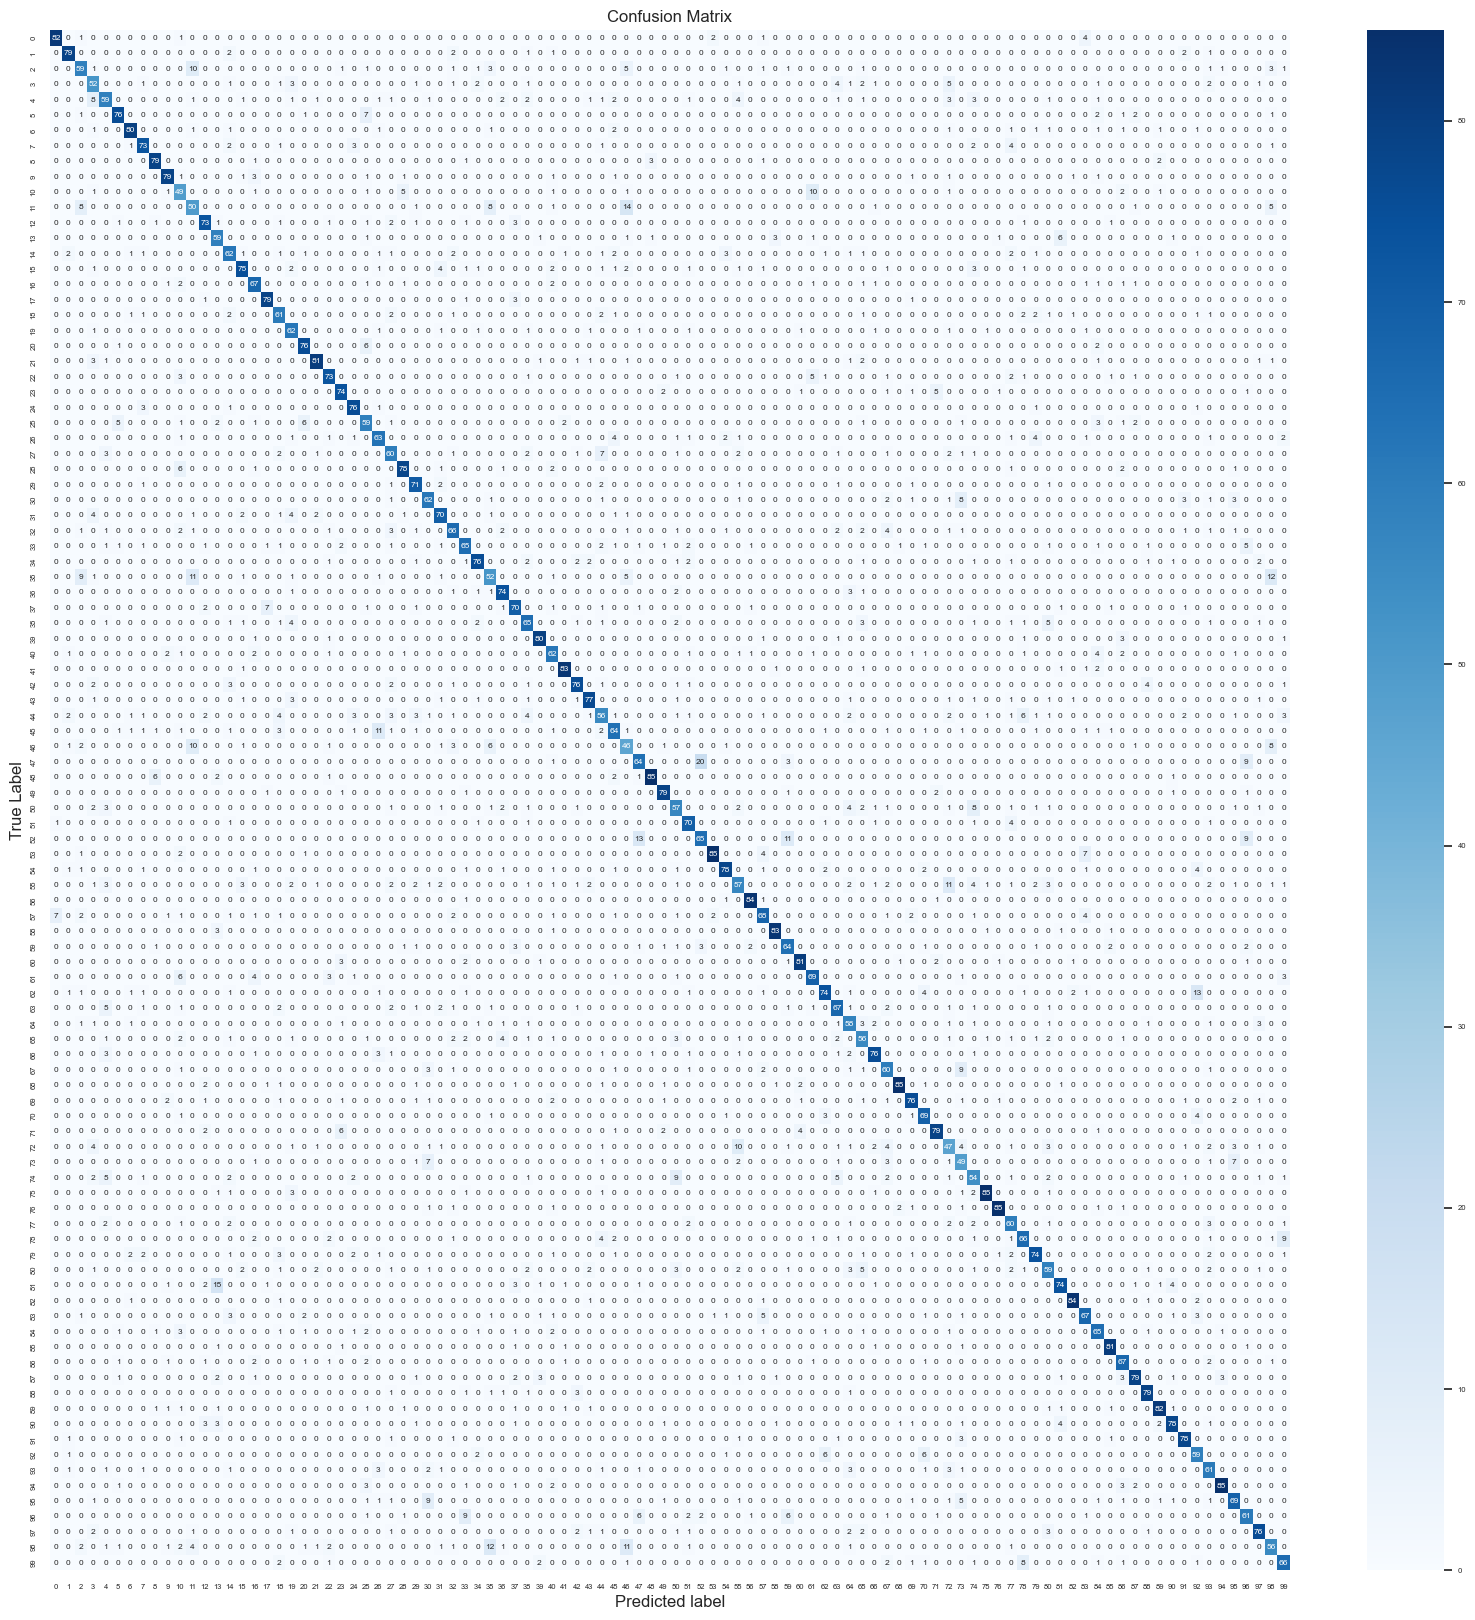

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(id_gt, id_pred)
matrix_df = pd.DataFrame(cm)

plt.figure(figsize=[20, 20])
sns.set(font_scale=0.5)
sns.heatmap(matrix_df, annot=True, fmt="g", cmap="Blues")#set axis titles
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

plt.show()

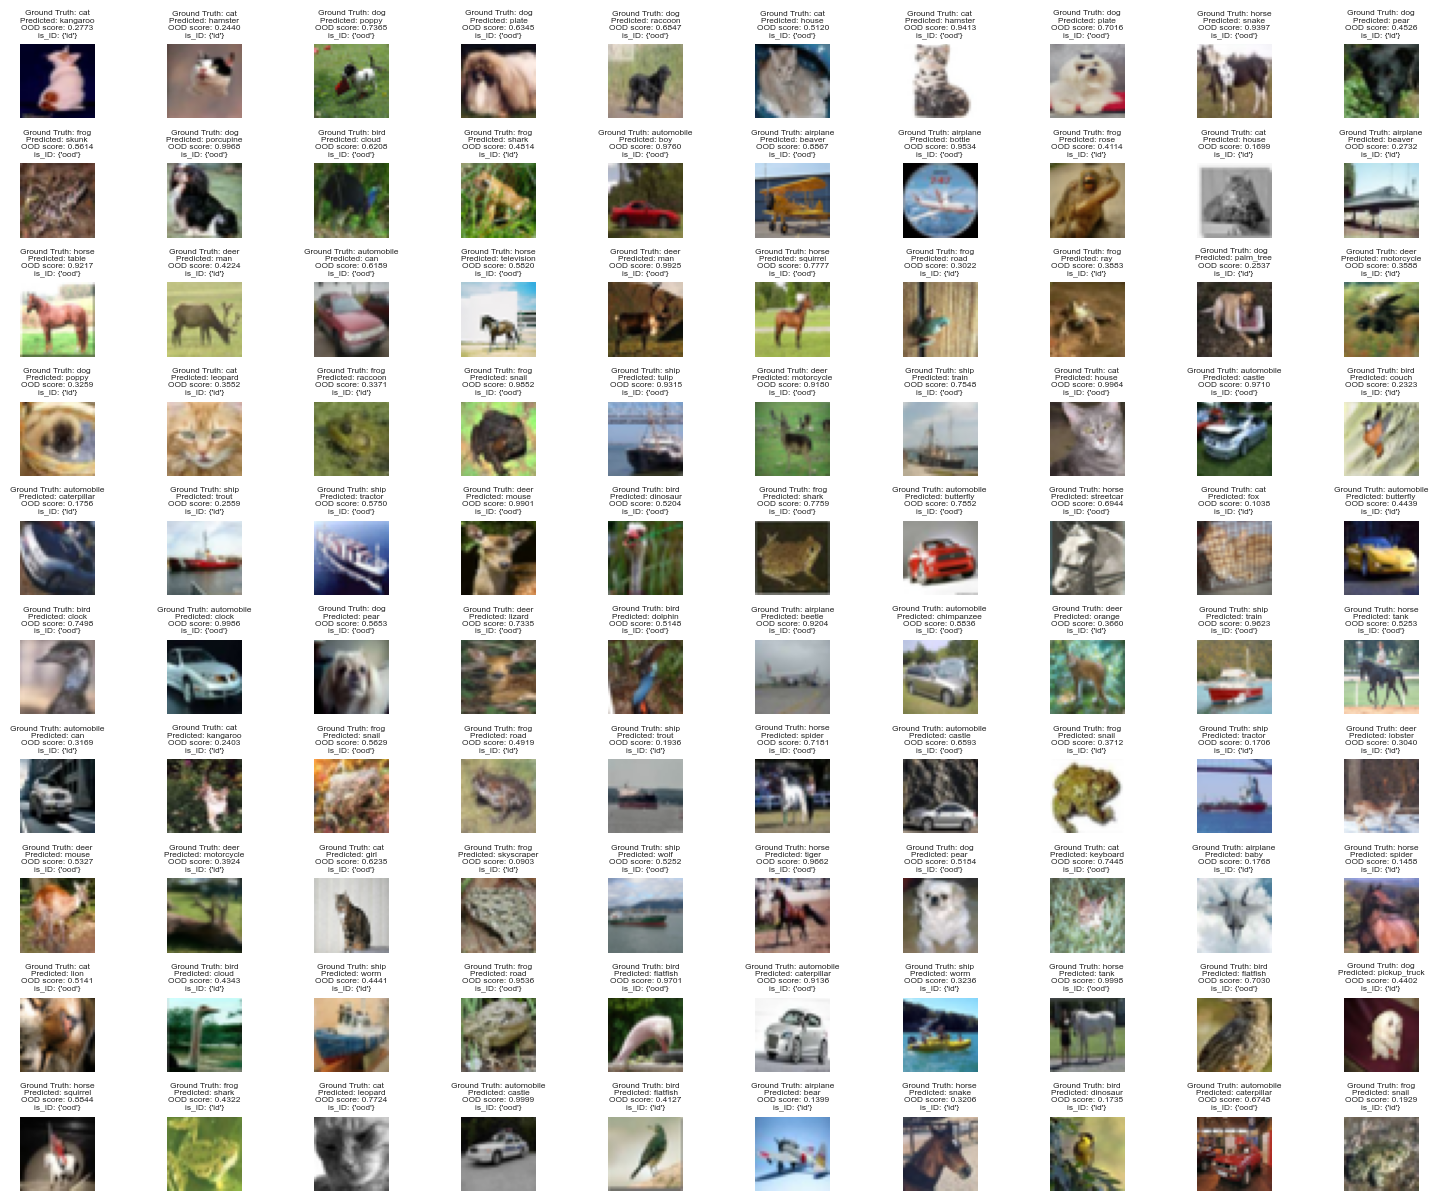

In [78]:
# Extract data
ood_gt_cifar10 = evaluator.scores['ood']['near']['cifar10'][0]
ood_conf_cifar10 = evaluator.scores['ood']['near']['cifar10'][1]
ood_pred_cifar10 = evaluator.scores['ood']['near']['cifar10'][2]
ood_file_paths_cifar10 = evaluator.scores['ood']['near']['cifar10'][3]

classes_cifar10 = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
is_id_map = {0: "id", -1: "ood"}

# Create a figure and axis for plotting
fig, axes = plt.subplots(10, 10, figsize=(15, 12))

# Display the randomly selected images in a grid
for i, idx in enumerate(random_indices):
    row = i // 10
    col = i % 10

    image_path = ood_file_paths_cifar10[idx]
    img = mpimg.imread(image_path)
    # Extract class name from the file path
    class_name = image_path.split('/')[-2]  # Adjust the split as per your file path structure
    
    # Ground truth label (converted to string)
    ground_truth = class_name
    predicted_label = classes_cifar100[id_pred[idx]]
    score = ood_conf_cifar10[idx]
    is_id = {"ood" if score > 0.5 else "id"}

    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Ground Truth: {ground_truth}\nPredicted: {predicted_label}\nOOD score: {score:.4f}\nis_ID: {is_id}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
